# Model Analysis: Why High Train/Test Accuracy but Poor Inference?

This notebook investigates the discrepancy between:
- **High training/test accuracy** (~100%)
- **Poor real-world inference** (low confidence, wrong predictions)

Common causes:
1. Data leakage (near-duplicate images in train/test)
2. Class imbalance
3. Distribution shift (training vs inference conditions)
4. Preprocessing mismatch


In [32]:
import sys
sys.path.insert(0, '..')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from datetime import datetime
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import mlflow

from src.cv_model.preprocessing import create_dataloaders, get_val_transforms, IMAGENET_MEAN, IMAGENET_STD
from src.cv_model.train import get_model, MLFLOW_TRACKING_URI

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_DIR = Path('../data/raw')
MODELS_DIR = Path('../models')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLFLOW_TRACKING_URI = f"file:///{MODELS_DIR.absolute()}/mlruns"
# Setup MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f'Device: {DEVICE}')
print(MLFLOW_TRACKING_URI)

Device: cpu
file:///c:\Users\fibla\Documents\Mano\notebooks\..\models/mlruns


## 1. Load Model and Training Metrics


In [33]:
# Find best run from MLflow
experiment_name = "colab_mobilenet_v2"

experiment = mlflow.get_experiment_by_name(experiment_name)

c:\Users\fibla\.local\share\mamba\envs\Mano\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [37]:
# Find best run from MLflow
experiment_name = "colab_mobilenet_v2"

experiment = mlflow.get_experiment_by_name(experiment_name)
if not experiment:
    raise FileNotFoundError(f'No experiment found with name: {experiment_name}')

# Get the best run by test accuracy
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.test_acc DESC"],
    max_results=1,
)

if runs.empty:
    raise FileNotFoundError('No runs found in experiment')

run_id = runs.iloc[0]['run_id']
print(f'Using best run: {run_id}')

# Get run info
run = mlflow.get_run(run_id)
params = run.data.params
metrics = run.data.metrics

model_name = params.get('model_name', 'mobilenet_v2')
num_classes = int(params.get('num_classes', 26))
classes = params.get('classes', '').split(',')
val_acc = metrics.get('best_val_acc', 0)
test_acc = metrics.get('test_acc', 0)

print(f'Model: {model_name}')
print(f'Classes ({num_classes}): {classes}')
print(f'Best validation accuracy: {val_acc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')


Using best run: 27d1b5d84a1644b58c7708c63d093a39
Model: mobilenet_v2
Classes (26): ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Best validation accuracy: 1.0000
Test accuracy: 1.0000


In [44]:
# Load checkpoint from MLflow artifacts directory
# For local file store, we can access artifacts directly
mlruns_dir = MODELS_DIR / 'mlruns'

# Find the experiment directory and run artifacts
checkpoint_path = None
for exp_dir in mlruns_dir.iterdir():
    if exp_dir.is_dir() and exp_dir.name not in ['0', 'models']:
        run_dir = exp_dir / run_id / 'artifacts' / 'checkpoints'
        if run_dir.exists():
            checkpoint_files = list(run_dir.glob("*.pth"))
            if checkpoint_files:
                checkpoint_path = sorted(checkpoint_files)[-1]
                break

if checkpoint_path is None:
    raise FileNotFoundError(f"No checkpoint found for run {run_id}")

print(f"Loading checkpoint: {checkpoint_path.name}")
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)

# Load model
model = get_model(model_name, num_classes, pretrained=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)
model.eval()
print('\nModel loaded successfully from MLflow!')


Loading checkpoint: mobilenet_v2_v1_acc1.00_20251127_204309.pth

Model loaded successfully from MLflow!


## 2. Training Curves Analysis

Let's load and visualize the training metrics from MLflow.


In [ ]:
# Load metrics from MLflow using the run_id from previous cell
metrics_data = {}

# Get metric history for the run
client = mlflow.tracking.MlflowClient()

metric_names = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'learning_rate']
for metric_name in metric_names:
    try:
        history = client.get_metric_history(run_id, metric_name)
        if history:
            values = [(m.step, m.value) for m in history]
            metrics_data[metric_name] = sorted(values, key=lambda x: x[0])
    except Exception as e:
        print(f"Could not load {metric_name}: {e}")

print(f'Loaded metrics: {list(metrics_data.keys())}')


Loaded metrics: ['best_val_acc', 'learning_rate', 'test_acc', 'test_loss', 'train_acc', 'train_loss', 'val_acc', 'val_loss']


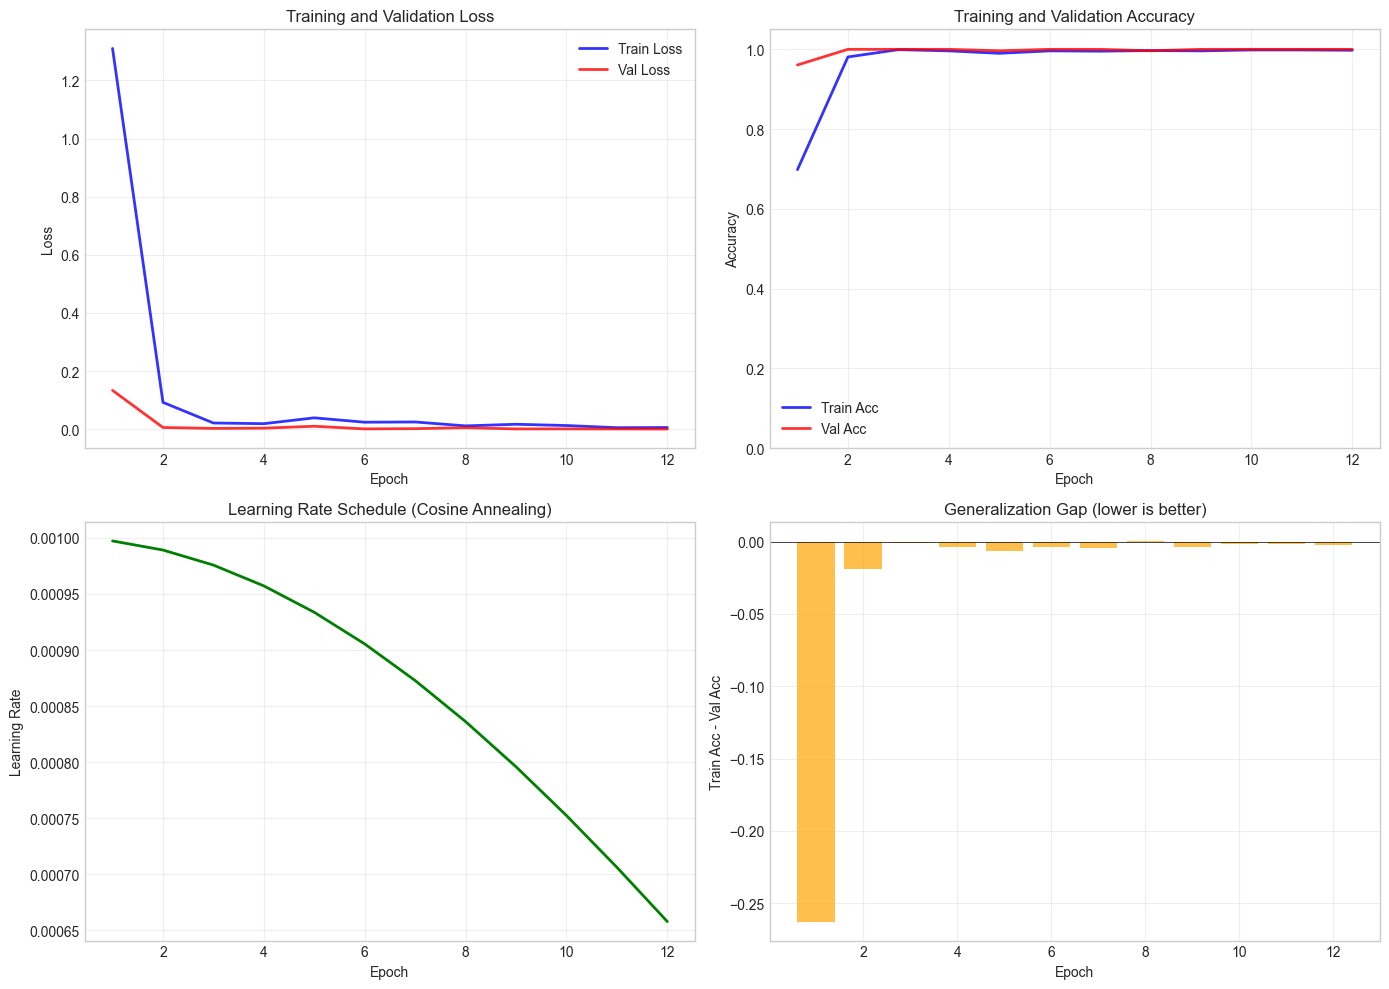


⚠️ OBSERVATION: If train and val accuracy are both very high very quickly,
   this suggests the model is memorizing near-duplicate images.


In [46]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
ax1 = axes[0, 0]
if 'train_loss' in metrics_data:
    steps, values = zip(*metrics_data['train_loss'])
    ax1.plot(steps, values, 'b-', linewidth=2, label='Train Loss', alpha=0.8)
if 'val_loss' in metrics_data:
    steps, values = zip(*metrics_data['val_loss'])
    ax1.plot(steps, values, 'r-', linewidth=2, label='Val Loss', alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2 = axes[0, 1]
if 'train_acc' in metrics_data:
    steps, values = zip(*metrics_data['train_acc'])
    ax2.plot(steps, values, 'b-', linewidth=2, label='Train Acc', alpha=0.8)
if 'val_acc' in metrics_data:
    steps, values = zip(*metrics_data['val_acc'])
    ax2.plot(steps, values, 'r-', linewidth=2, label='Val Acc', alpha=0.8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_ylim(0, 1.05)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning rate
ax3 = axes[1, 0]
if 'learning_rate' in metrics_data:
    steps, values = zip(*metrics_data['learning_rate'])
    ax3.plot(steps, values, 'g-', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule (Cosine Annealing)')
ax3.grid(True, alpha=0.3)

# Overfitting gap
ax4 = axes[1, 1]
if 'train_acc' in metrics_data and 'val_acc' in metrics_data:
    train_steps, train_vals = zip(*metrics_data['train_acc'])
    val_steps, val_vals = zip(*metrics_data['val_acc'])
    # Compute gap
    gap = [t - v for t, v in zip(train_vals, val_vals)]
    ax4.bar(train_steps, gap, color='orange', alpha=0.7)
    ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Train Acc - Val Acc')
ax4.set_title('Generalization Gap (lower is better)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n⚠️ OBSERVATION: If train and val accuracy are both very high very quickly,')
print('   this suggests the model is memorizing near-duplicate images.')


## 3. Data Leakage Analysis: Temporal Correlation

Check if images were captured too quickly, resulting in near-duplicates.


In [47]:
# Analyze capture timestamps
capture_stats = {}

for letter_dir in sorted(DATA_DIR.iterdir()):
    if not letter_dir.is_dir():
        continue
    
    timestamps = []
    for img_path in letter_dir.glob('*.jpg'):
        # Parse timestamp from filename: a_0001_20251127_181813.jpg
        parts = img_path.stem.split('_')
        if len(parts) >= 4:
            try:
                dt_str = f"{parts[2]}_{parts[3]}"
                dt = datetime.strptime(dt_str, '%Y%m%d_%H%M%S')
                timestamps.append(dt)
            except:
                pass
    
    if timestamps:
        timestamps.sort()
        # Calculate time span
        span_seconds = (timestamps[-1] - timestamps[0]).total_seconds()
        capture_rate = len(timestamps) / max(span_seconds, 1)  # images per second
        capture_stats[letter_dir.name.upper()] = {
            'count': len(timestamps),
            'span_seconds': span_seconds,
            'capture_rate': capture_rate
        }

print('Capture Statistics per Letter:')
print('-' * 60)
print(f'{"Letter":^8} {"Count":^8} {"Span (s)":^12} {"Rate (img/s)":^14}')
print('-' * 60)
for letter, stats in sorted(capture_stats.items()):
    print(f'{letter:^8} {stats["count"]:^8} {stats["span_seconds"]:^12.1f} {stats["capture_rate"]:^14.2f}')

avg_rate = np.mean([s['capture_rate'] for s in capture_stats.values()])
print('-' * 60)
print(f'\n⚠️ Average capture rate: {avg_rate:.2f} images/second')
print('   High capture rates (>5 img/s) mean near-duplicate images!')


Capture Statistics per Letter:
------------------------------------------------------------
 Letter   Count     Span (s)    Rate (img/s) 
------------------------------------------------------------
   A        91        7.0          13.00     
   B        46        3.0          15.33     
   C        51        5.0          10.20     
   D        51        10.0          5.10     
   E        52        8.0           6.50     
   F        75        6.0          12.50     
   G        51        5.0          10.20     
   H        60        4.0          15.00     
   I        61        6.0          10.17     
   J        64        4.0          16.00     
   K        60        9.0           6.67     
   L        64        5.0          12.80     
   M        76        5.0          15.20     
   N        57        4.0          14.25     
   O        93        7.0          13.29     
   P        62        9.0           6.89     
   Q        59        4.0          14.75     
   R        53     

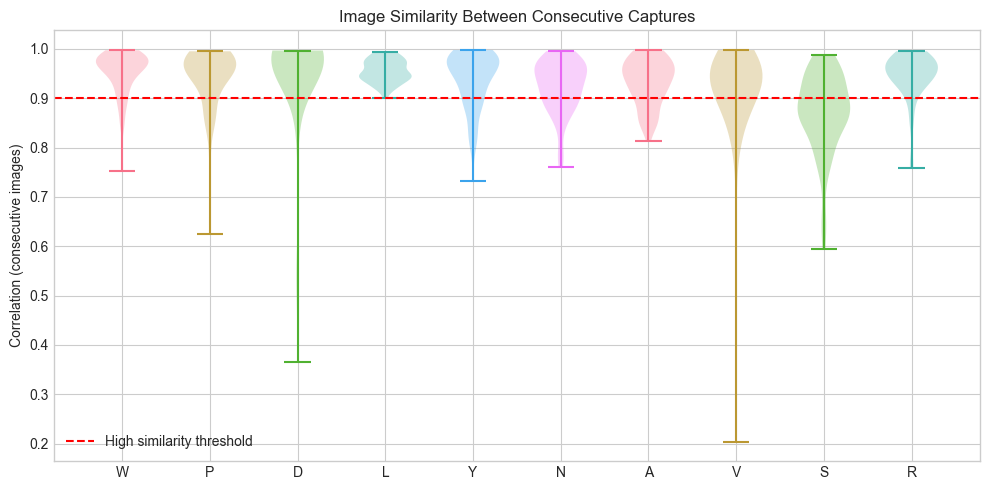


⚠️ Correlation > 0.9 indicates near-duplicate images!
   This causes data leakage when split into train/val/test.


In [48]:
# Visualize image similarity within a class
def compute_image_similarity(img1, img2):
    """Compute structural similarity between two images."""
    # Resize to same size
    size = (100, 100)
    img1_resized = cv2.resize(img1, size)
    img2_resized = cv2.resize(img2, size)
    
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)
    
    # Compute correlation
    return np.corrcoef(gray1.flatten(), gray2.flatten())[0, 1]

# Sample similarity analysis for a few letters
sample_letters = ['a', 't', 'b']  # high, high, low count
similarity_results = {}
all_letters = ['a', 't', 'b', 's', 'd', 'n', 'c', 'm', 'p', 'l', 'g', 'r', 'v', 'w', 'x', 'y', 'z']
sample_letters = np.random.choice(all_letters, size=10, replace=False)
for letter in sample_letters:
    letter_dir = DATA_DIR / letter
    if not letter_dir.exists():
        continue
        
    images = sorted(list(letter_dir.glob('*.jpg')))# First 20 images
    
    if len(images) < 5:
        continue
    
    # Compute pairwise similarities for consecutive images
    similarities = []
    for i in range(len(images) - 1):
        img1 = cv2.imread(str(images[i]))
        img2 = cv2.imread(str(images[i + 1]))
        if img1 is not None and img2 is not None:
            sim = compute_image_similarity(img1, img2)
            similarities.append(sim)
    
    similarity_results[letter.upper()] = similarities

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
positions = []
labels = []

for i, (letter, sims) in enumerate(similarity_results.items()):
    if sims:
        positions.append(i)
        labels.append(letter)
        ax.violinplot([sims], positions=[i], widths=0.6)

ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel('Correlation (consecutive images)')
ax.set_title('Image Similarity Between Consecutive Captures')
ax.axhline(y=0.9, color='r', linestyle='--', label='High similarity threshold')
ax.legend()
plt.tight_layout()
plt.show()

print('\n⚠️ Correlation > 0.9 indicates near-duplicate images!')
print('   This causes data leakage when split into train/val/test.')


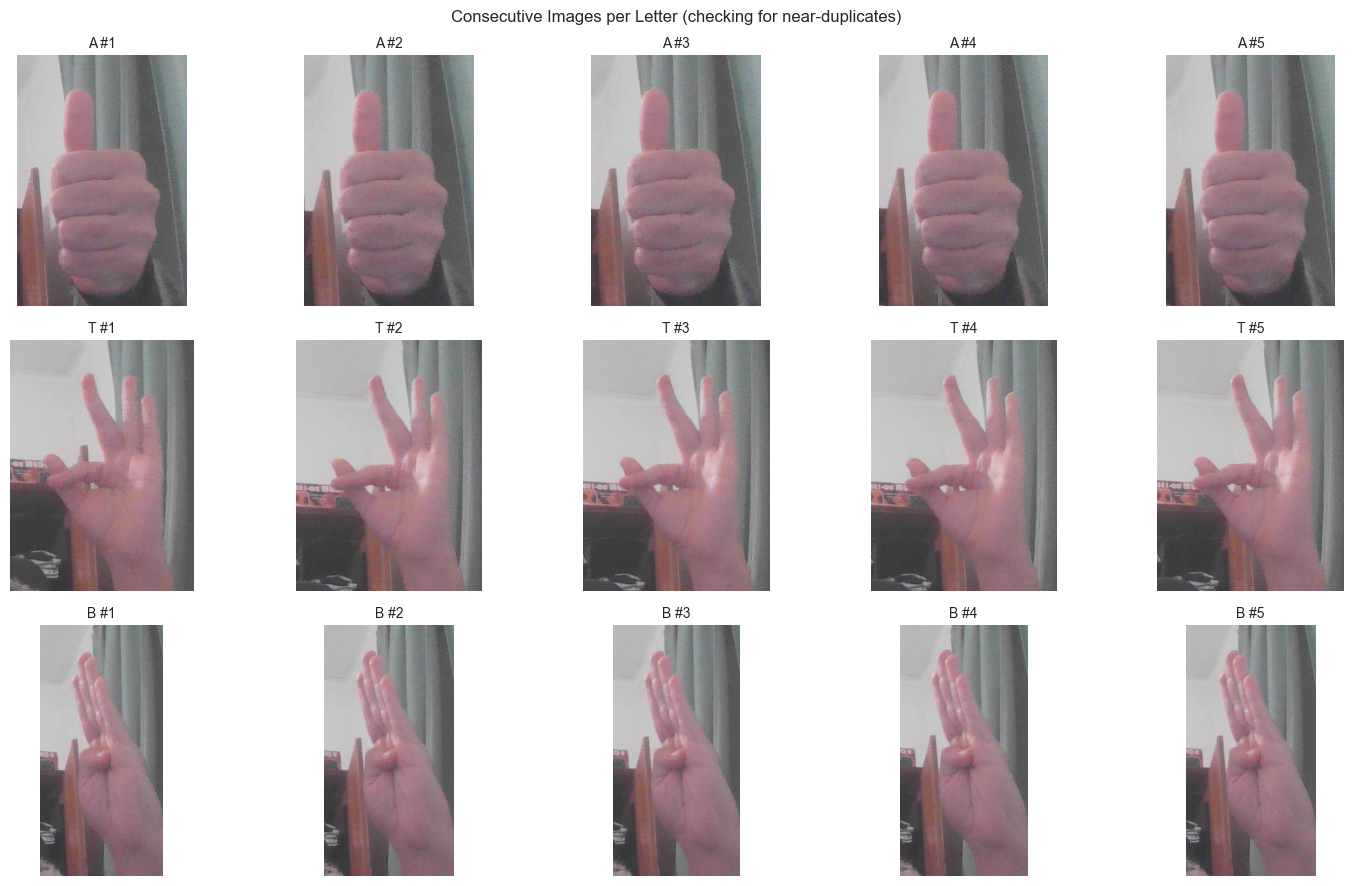


⚠️ If images look nearly identical, the model memorizes specific frames
   rather than learning generalizable features!


In [49]:
# Visualize consecutive images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for row, letter in enumerate(['a', 't', 'b']):
    letter_dir = DATA_DIR / letter
    if not letter_dir.exists():
        continue
        
    images = sorted(list(letter_dir.glob('*.jpg')))[:5]
    
    for col, img_path in enumerate(images):
        img = cv2.imread(str(img_path))
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img_rgb)
            axes[row, col].set_title(f'{letter.upper()} #{col+1}', fontsize=10)
        axes[row, col].axis('off')

plt.suptitle('Consecutive Images per Letter (checking for near-duplicates)', fontsize=12)
plt.tight_layout()
plt.show()

print('\n⚠️ If images look nearly identical, the model memorizes specific frames')
print('   rather than learning generalizable features!')


## 4. Class Imbalance Analysis


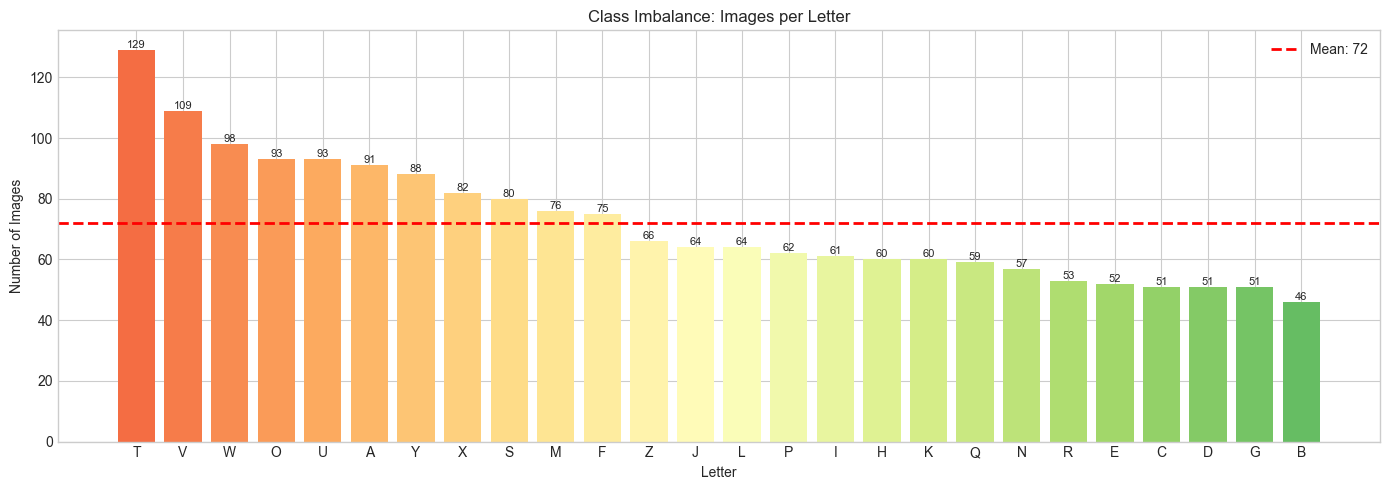


Class Balance Statistics:
  Min: 46 (B)
  Max: 129 (T)
  Mean: 72.0
  Std: 20.4
  Imbalance ratio: 2.80x

⚠️ T has the most samples - this might explain why T works best during inference!


In [50]:
# Count images per class
class_counts = {}
for letter_dir in DATA_DIR.iterdir():
    if letter_dir.is_dir():
        count = len(list(letter_dir.glob('*.jpg')))
        if count > 0:
            class_counts[letter_dir.name.upper()] = count

# Sort by count
sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(sorted_counts)))
bars = ax.bar(sorted_counts.keys(), sorted_counts.values(), color=colors)

# Add mean line
mean_count = np.mean(list(sorted_counts.values()))
ax.axhline(y=mean_count, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_count:.0f}')

ax.set_xlabel('Letter')
ax.set_ylabel('Number of Images')
ax.set_title('Class Imbalance: Images per Letter')
ax.legend()

# Annotate bars with counts
for bar, count in zip(bars, sorted_counts.values()):
    ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Statistics
counts = list(sorted_counts.values())
print(f'\nClass Balance Statistics:')
print(f'  Min: {min(counts)} ({min(sorted_counts, key=sorted_counts.get)})')
print(f'  Max: {max(counts)} ({max(sorted_counts, key=sorted_counts.get)})')
print(f'  Mean: {np.mean(counts):.1f}')
print(f'  Std: {np.std(counts):.1f}')
print(f'  Imbalance ratio: {max(counts)/min(counts):.2f}x')

print('\n⚠️ T has the most samples - this might explain why T works best during inference!')


## 5. Per-Class Performance Analysis


In [51]:
# Create dataloaders
train_loader, val_loader, test_loader, num_classes, class_names = create_dataloaders(
    data_dir=DATA_DIR,
    batch_size=32
)


Loaded 1871 images from 26 classes
Split sizes - Train: 1309, Val: 281, Test: 281
Loaded 1871 images from 26 classes
Loaded 1871 images from 26 classes
Loaded 1871 images from 26 classes


In [52]:
# Collect predictions on test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = probs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f'Test set size: {len(all_labels)}')
print(f'Overall accuracy: {(all_preds == all_labels).mean():.4f}')


Test set size: 281
Overall accuracy: 1.0000


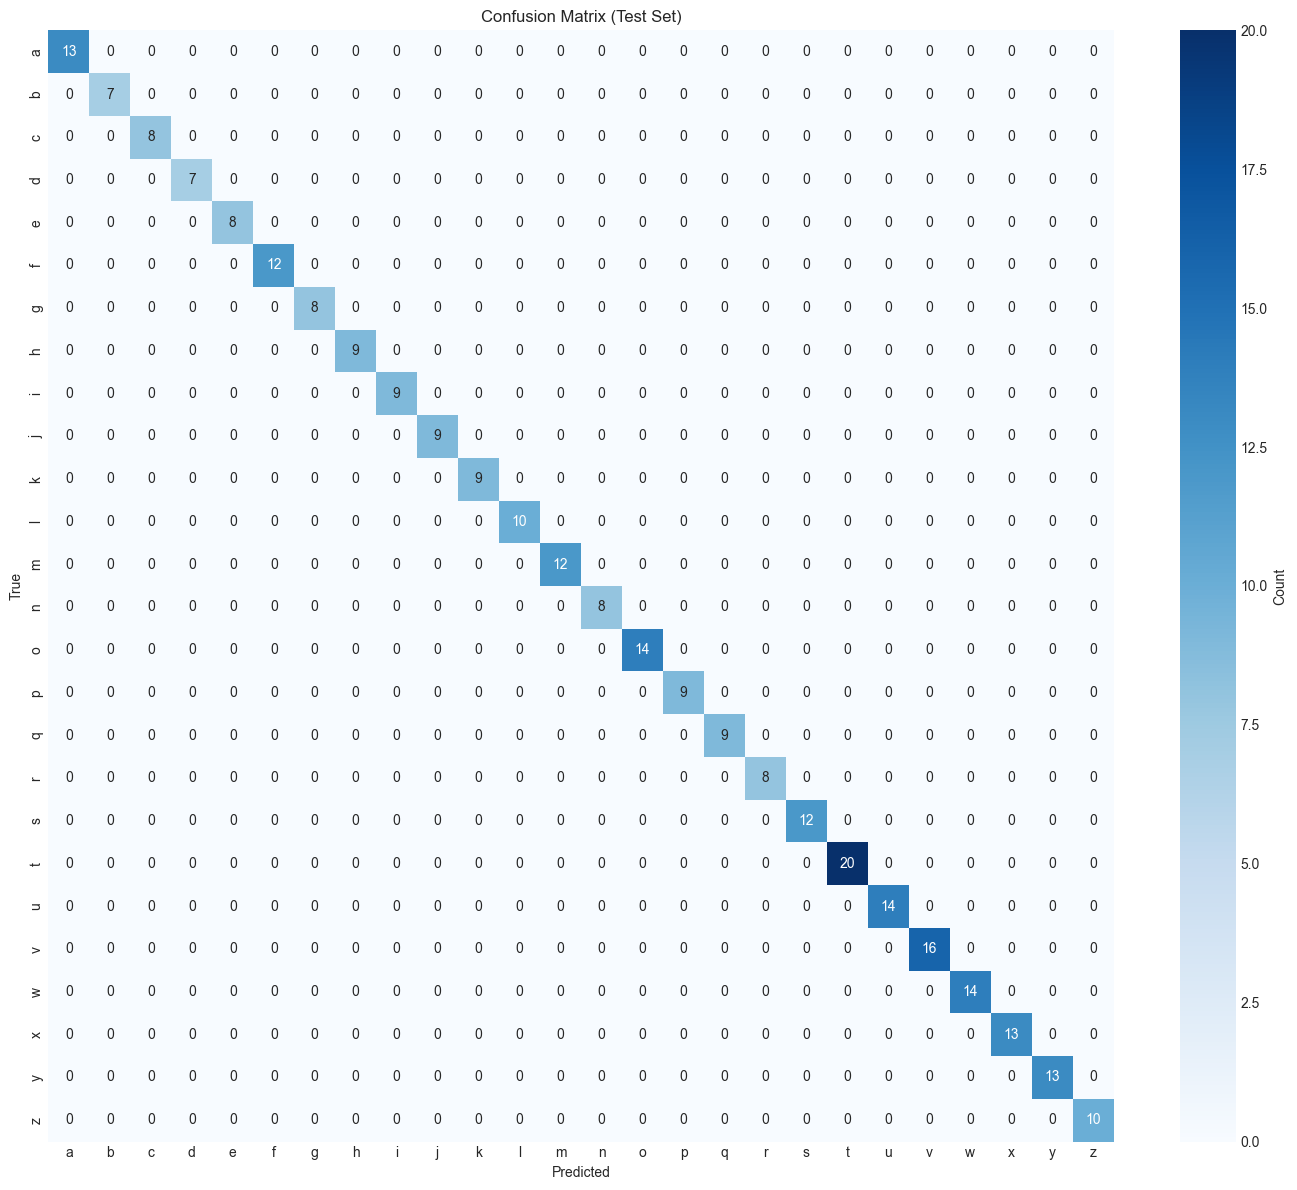

In [53]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.savefig('../notebooks/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [54]:
# Per-class metrics
print('\nPer-Class Performance:')
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))



Per-Class Performance:
              precision    recall  f1-score   support

           a      1.000     1.000     1.000        13
           b      1.000     1.000     1.000         7
           c      1.000     1.000     1.000         8
           d      1.000     1.000     1.000         7
           e      1.000     1.000     1.000         8
           f      1.000     1.000     1.000        12
           g      1.000     1.000     1.000         8
           h      1.000     1.000     1.000         9
           i      1.000     1.000     1.000         9
           j      1.000     1.000     1.000         9
           k      1.000     1.000     1.000         9
           l      1.000     1.000     1.000        10
           m      1.000     1.000     1.000        12
           n      1.000     1.000     1.000         8
           o      1.000     1.000     1.000        14
           p      1.000     1.000     1.000         9
           q      1.000     1.000     1.000         9
   

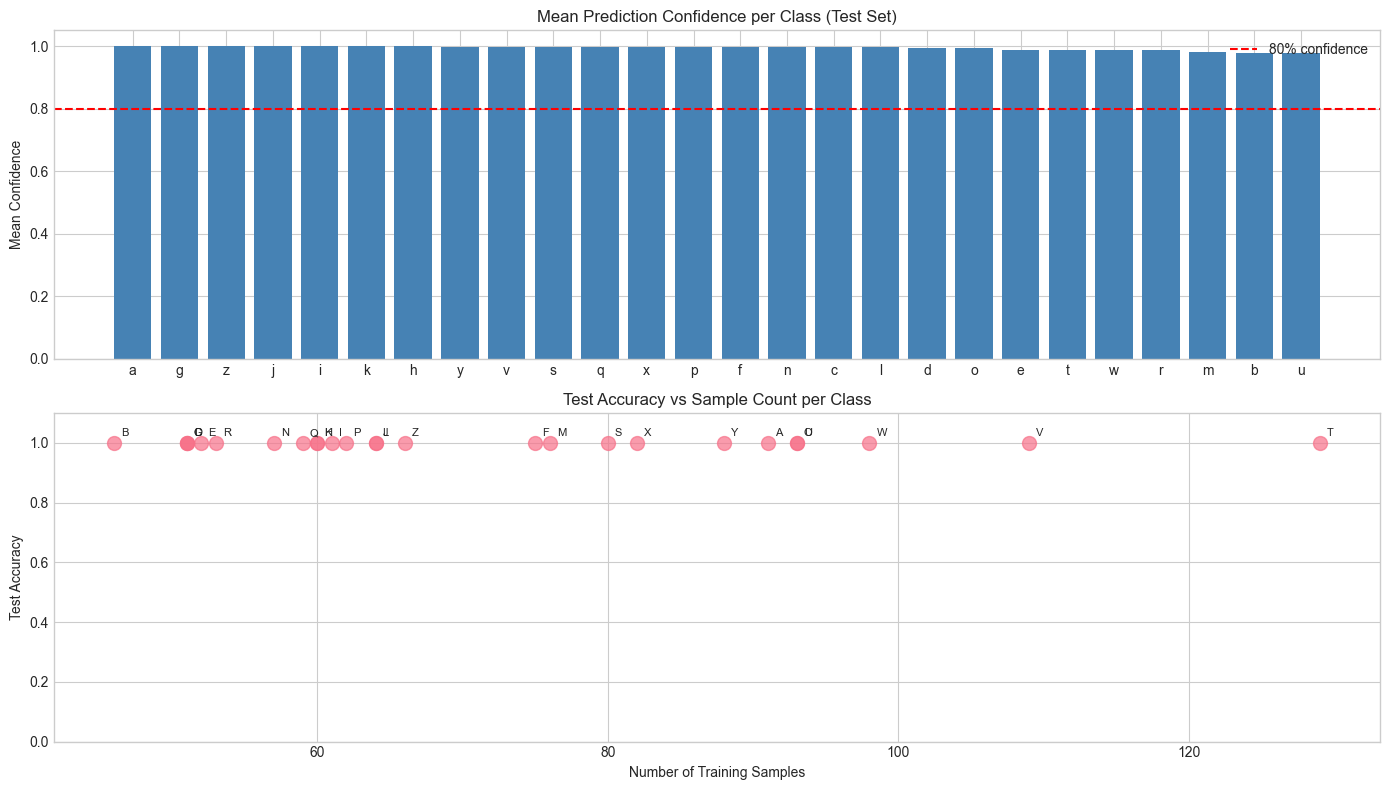

In [55]:
# Confidence distribution per class
confidences_per_class = defaultdict(list)

for i, (pred, label, probs) in enumerate(zip(all_preds, all_labels, all_probs)):
    conf = probs[pred]  # Confidence in the prediction
    is_correct = pred == label
    confidences_per_class[class_names[label]].append((conf, is_correct))

# Plot confidence distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Mean confidence per class
ax1 = axes[0]
mean_confs = {cls: np.mean([c[0] for c in confs]) for cls, confs in confidences_per_class.items()}
sorted_confs = dict(sorted(mean_confs.items(), key=lambda x: x[1], reverse=True))
ax1.bar(sorted_confs.keys(), sorted_confs.values(), color='steelblue')
ax1.axhline(y=0.8, color='r', linestyle='--', label='80% confidence')
ax1.set_ylabel('Mean Confidence')
ax1.set_title('Mean Prediction Confidence per Class (Test Set)')
ax1.legend()
ax1.set_ylim(0, 1.05)

# Accuracy vs sample count
ax2 = axes[1]
per_class_acc = {}
for cls in class_names:
    mask = all_labels == class_names.index(cls)
    if mask.sum() > 0:
        per_class_acc[cls] = (all_preds[mask] == all_labels[mask]).mean()

# Plot accuracy vs sample count
x = [class_counts.get(cls.upper(), 0) for cls in per_class_acc.keys()]
y = list(per_class_acc.values())
labels_plot = list(per_class_acc.keys())

ax2.scatter(x, y, s=100, alpha=0.7)
for i, label in enumerate(labels_plot):
    ax2.annotate(label.upper(), (x[i], y[i]), textcoords='offset points', 
                 xytext=(5, 5), fontsize=8)
ax2.set_xlabel('Number of Training Samples')
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Test Accuracy vs Sample Count per Class')
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


## 6. Train vs Inference Distribution Shift

Compare what training images look like vs what inference sees.


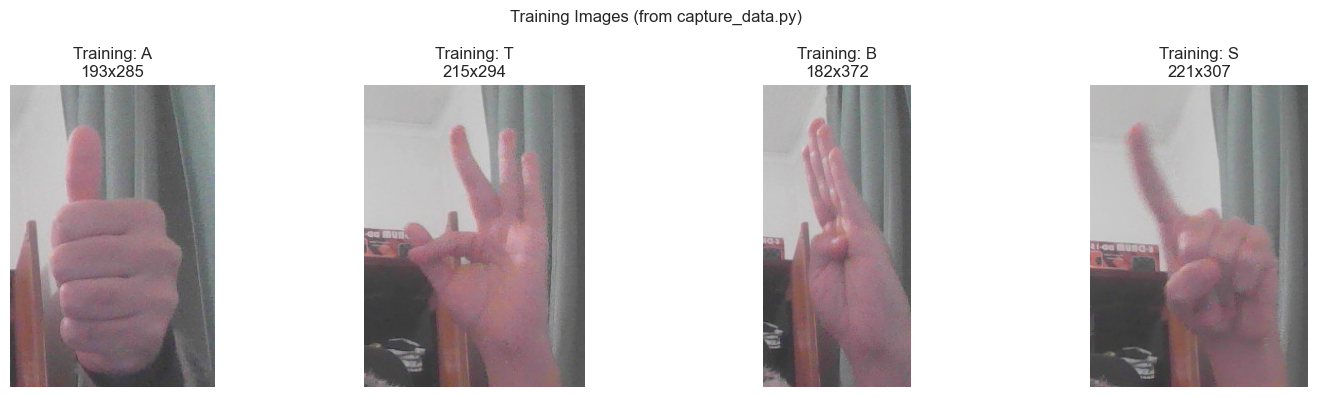


Key differences to check between training and inference:
1. Background: Are training backgrounds similar to inference environment?
2. Lighting: Is lighting consistent?
3. Hand position: Is the hand in similar position/angle?
4. Crop size: Training crops may be tighter or looser than MediaPipe crops


In [56]:
# Load sample training images
sample_training_images = []
for letter in ['a', 't', 'b', 's']:
    letter_dir = DATA_DIR / letter
    if letter_dir.exists():
        img_path = next(letter_dir.glob('*.jpg'), None)
        if img_path:
            img = cv2.imread(str(img_path))
            sample_training_images.append((letter.upper(), img))

# Display training images
fig, axes = plt.subplots(1, len(sample_training_images), figsize=(15, 4))
for ax, (letter, img) in zip(axes, sample_training_images):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(f'Training: {letter}\n{img.shape[1]}x{img.shape[0]}')
    ax.axis('off')
plt.suptitle('Training Images (from capture_data.py)', fontsize=12)
plt.tight_layout()
plt.show()

print('\nKey differences to check between training and inference:')
print('1. Background: Are training backgrounds similar to inference environment?')
print('2. Lighting: Is lighting consistent?')
print('3. Hand position: Is the hand in similar position/angle?')
print('4. Crop size: Training crops may be tighter or looser than MediaPipe crops')


## 7. Simulate Inference Conditions

Test model on images with simulated real-world variations.



Letter T under different conditions:
  Original       : Pred=T, Conf=98.7%
  Bright         : Pred=T, Conf=97.6%
  Dark           : Pred=T, Conf=96.1%
  Blurred        : Pred=T, Conf=44.6%
  Color Shift    : Pred=U, Conf=38.0%
  Rotated 15°    : Pred=T, Conf=96.6%


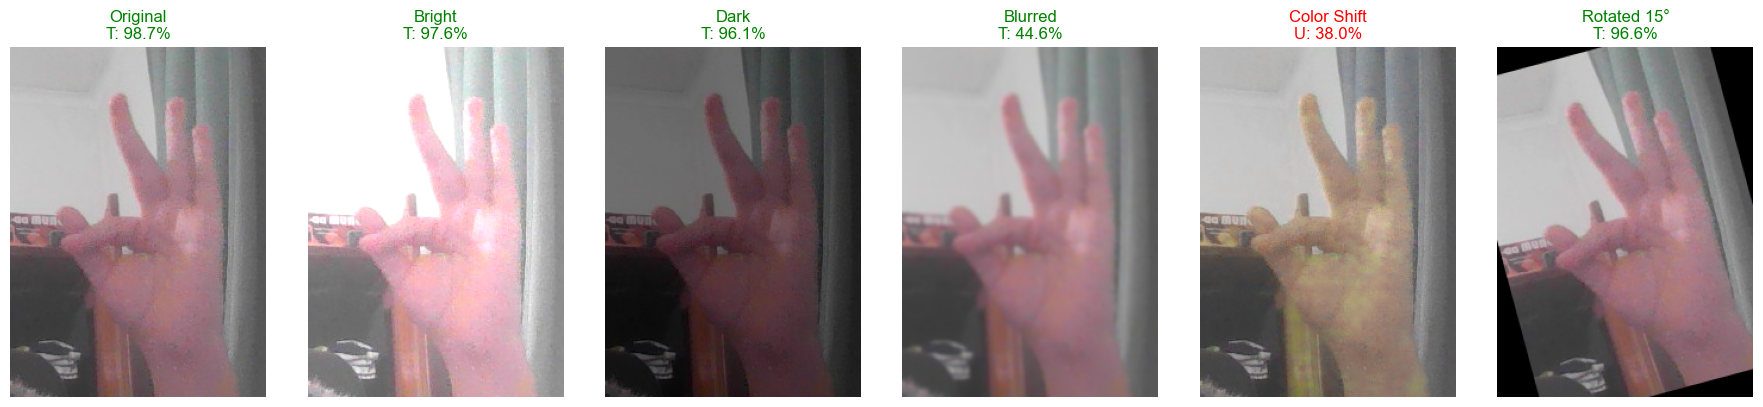


Letter A under different conditions:
  Original       : Pred=A, Conf=100.0%
  Bright         : Pred=A, Conf=100.0%
  Dark           : Pred=A, Conf=99.4%
  Blurred        : Pred=A, Conf=99.3%
  Color Shift    : Pred=A, Conf=94.3%
  Rotated 15°    : Pred=A, Conf=100.0%


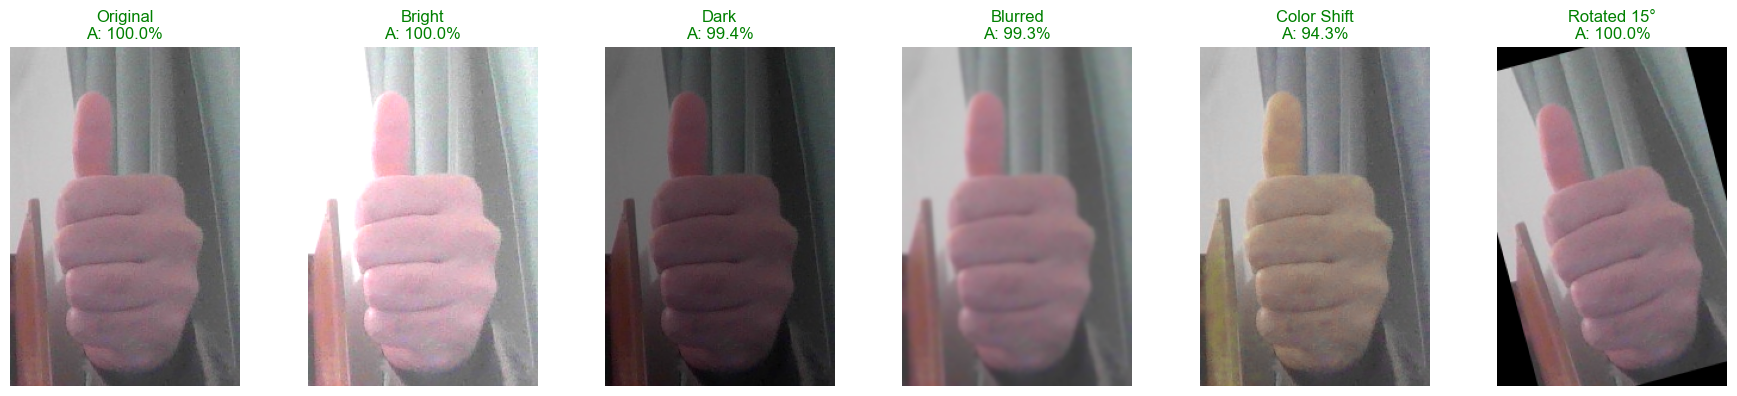


Letter B under different conditions:
  Original       : Pred=B, Conf=99.6%
  Bright         : Pred=B, Conf=99.4%
  Dark           : Pred=B, Conf=99.2%
  Blurred        : Pred=B, Conf=97.7%
  Color Shift    : Pred=B, Conf=83.8%
  Rotated 15°    : Pred=B, Conf=91.9%


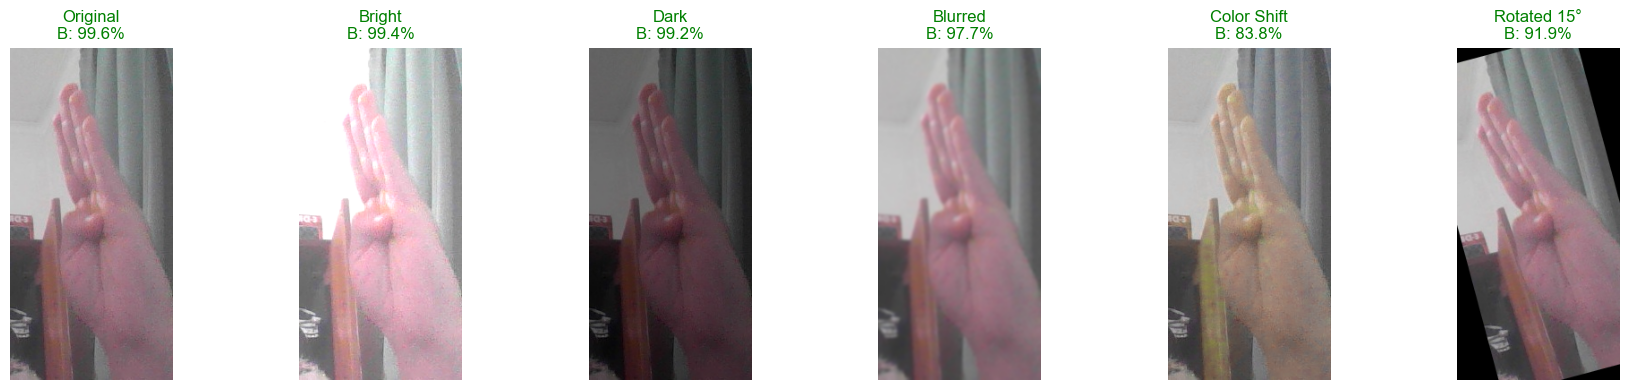

In [57]:
def apply_realistic_augmentations(img):
    """Apply augmentations that simulate real inference conditions."""
    augmentations = []
    
    # Original
    augmentations.append(('Original', img.copy()))
    
    # Brightness variations
    bright = cv2.convertScaleAbs(img, alpha=1.3, beta=30)
    augmentations.append(('Bright', bright))
    
    dark = cv2.convertScaleAbs(img, alpha=0.7, beta=-30)
    augmentations.append(('Dark', dark))
    
    # Blur (motion/focus)
    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    augmentations.append(('Blurred', blurred))
    
    # Color shift
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 0] = (hsv[:, :, 0] + 20) % 180
    color_shifted = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    augmentations.append(('Color Shift', color_shifted))
    
    # Rotation
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), 15, 1)
    rotated = cv2.warpAffine(img, M, (w, h))
    augmentations.append(('Rotated 15°', rotated))
    
    return augmentations

# Test on sample images
transform = get_val_transforms()

for letter in ['t', 'a', 'b']:  # T works well, test others too
    letter_dir = DATA_DIR / letter
    if not letter_dir.exists():
        continue
        
    img_path = next(letter_dir.glob('*.jpg'), None)
    if not img_path:
        continue
        
    img = cv2.imread(str(img_path))
    augmentations = apply_realistic_augmentations(img)
    
    fig, axes = plt.subplots(1, len(augmentations), figsize=(18, 4))
    
    print(f'\nLetter {letter.upper()} under different conditions:')
    
    for ax, (name, aug_img) in zip(axes, augmentations):
        # Show image
        img_rgb = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        
        # Predict
        pil_img = Image.fromarray(img_rgb)
        tensor = transform(pil_img).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            output = model(tensor)
            probs = F.softmax(output, dim=1)
            conf, pred_idx = probs.max(1)
            pred_letter = class_names[pred_idx.item()]
            
        color = 'green' if pred_letter == letter else 'red'
        ax.set_title(f'{name}\n{pred_letter.upper()}: {conf.item():.1%}', color=color)
        ax.axis('off')
        
        print(f'  {name:15}: Pred={pred_letter.upper()}, Conf={conf.item():.1%}')
    
    plt.tight_layout()
    plt.show()


## 8. Diagnosis Summary and Recommendations


In [58]:
print('=' * 70)
print('DIAGNOSIS SUMMARY')
print('=' * 70)

issues_found = []

# Check 1: Perfect accuracy
test_acc = (all_preds == all_labels).mean()
if test_acc > 0.98:
    issues_found.append({
        'issue': 'Suspiciously High Test Accuracy',
        'detail': f'Test accuracy is {test_acc:.1%} which indicates likely data leakage',
        'fix': 'Use temporal splits: all images from one capture session should be in same split'
    })

# Check 2: Class imbalance
imbalance_ratio = max(class_counts.values()) / min(class_counts.values())
if imbalance_ratio > 2:
    issues_found.append({
        'issue': 'Class Imbalance',
        'detail': f'Imbalance ratio is {imbalance_ratio:.1f}x (T has most, B has least)',
        'fix': 'Collect more data for under-represented classes or use class weights'
    })

# Check 3: Near-duplicate images
avg_capture_rate = np.mean([s['capture_rate'] for s in capture_stats.values()])
if avg_capture_rate > 5:
    issues_found.append({
        'issue': 'Near-Duplicate Images',
        'detail': f'Capture rate is {avg_capture_rate:.1f} images/second - images are nearly identical',
        'fix': 'Capture images with more variation (different poses, angles, lighting)'
    })

# Check 4: Small dataset
total_images = sum(class_counts.values())
if total_images < 2000:
    issues_found.append({
        'issue': 'Limited Dataset Size',
        'detail': f'Only {total_images} images total, may not capture enough variation',
        'fix': 'Collect more diverse data or use heavy augmentation'
    })

# Print issues
print(f'\nFound {len(issues_found)} potential issues:\n')
for i, issue in enumerate(issues_found, 1):
    print(f'{i}. {issue["issue"]}')
    print(f'   Problem: {issue["detail"]}')
    print(f'   Solution: {issue["fix"]}')
    print()

print('=' * 70)
print('RECOMMENDED ACTIONS')
print('=' * 70)
print('''
1. DATA COLLECTION:
   - Capture images with MORE VARIATION per gesture
   - Vary: hand position, rotation, lighting, background
   - Slower capture rate (1-2 images/second max)
   - Multiple capture sessions per letter

2. DATA SPLITTING:
   - Use TEMPORAL splits: keep all images from same session together
   - Alternative: Group-based splits by capture timestamp
   - This prevents data leakage from near-duplicate images

3. AUGMENTATION:
   - Add stronger augmentation during training:
     - Random brightness/contrast changes
     - Random blur (simulates motion)
     - More aggressive rotation/scaling
     - Background variation (if possible)

4. INFERENCE PIPELINE:
   - Verify preprocessing matches training exactly
   - Consider temporal smoothing (average predictions over frames)
   - Add confidence thresholds

5. IMMEDIATE TEST:
   - Try inference on the EXACT same images used for test set
   - If that works but live camera doesn't → distribution shift
   - If that also fails → preprocessing mismatch
''')


DIAGNOSIS SUMMARY

Found 4 potential issues:

1. Suspiciously High Test Accuracy
   Problem: Test accuracy is 100.0% which indicates likely data leakage
   Solution: Use temporal splits: all images from one capture session should be in same split

2. Class Imbalance
   Problem: Imbalance ratio is 2.8x (T has most, B has least)
   Solution: Collect more data for under-represented classes or use class weights

3. Near-Duplicate Images
   Problem: Capture rate is 12.2 images/second - images are nearly identical
   Solution: Capture images with more variation (different poses, angles, lighting)

4. Limited Dataset Size
   Problem: Only 1871 images total, may not capture enough variation
   Solution: Collect more diverse data or use heavy augmentation

RECOMMENDED ACTIONS

1. DATA COLLECTION:
   - Capture images with MORE VARIATION per gesture
   - Vary: hand position, rotation, lighting, background
   - Slower capture rate (1-2 images/second max)
   - Multiple capture sessions per letter



## 9. Quick Sanity Check: Inference Pipeline on Training Images


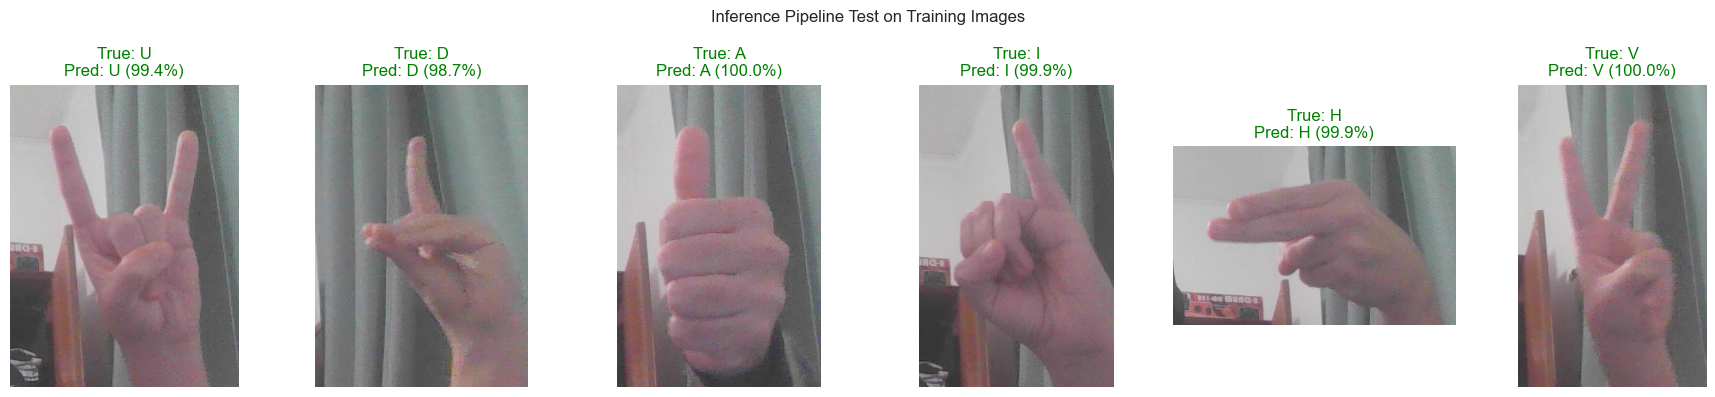


If these predictions are correct with high confidence, but live camera fails,
then the issue is distribution shift between training images and live camera.

Key insight: Training images were captured in controlled conditions.
Live inference sees different: lighting, hand position, background, crop size.


In [59]:
# Test inference pipeline on actual training images using the SAME transform as inference.py
from src.cv_model.inference import get_inference_transform

inference_transform = get_inference_transform()

# Pick random images from each class
import random
random.seed(42)

sample_results = []
for letter in random.sample(class_names, min(6, len(class_names))):
    letter_dir = DATA_DIR / letter
    if not letter_dir.exists():
        continue
        
    img_paths = list(letter_dir.glob('*.jpg'))
    if not img_paths:
        continue
        
    img_path = random.choice(img_paths)
    
    # Load as BGR (like OpenCV in inference.py)
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Apply inference transform
    tensor = inference_transform(img_rgb).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(tensor)
        probs = F.softmax(output, dim=1)
        conf, pred_idx = probs.max(1)
        pred_letter = class_names[pred_idx.item()]
    
    sample_results.append({
        'true': letter,
        'pred': pred_letter,
        'conf': conf.item(),
        'correct': letter == pred_letter,
        'img': img_rgb
    })

# Visualize
fig, axes = plt.subplots(1, len(sample_results), figsize=(18, 4))
for ax, result in zip(axes, sample_results):
    ax.imshow(result['img'])
    color = 'green' if result['correct'] else 'red'
    ax.set_title(f"True: {result['true'].upper()}\nPred: {result['pred'].upper()} ({result['conf']:.1%})", 
                 color=color)
    ax.axis('off')

plt.suptitle('Inference Pipeline Test on Training Images', fontsize=12)
plt.tight_layout()
plt.show()

print('\nIf these predictions are correct with high confidence, but live camera fails,')
print('then the issue is distribution shift between training images and live camera.')
print('\nKey insight: Training images were captured in controlled conditions.')
print('Live inference sees different: lighting, hand position, background, crop size.')
